In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
import matplotlib

# Plot formats

In [2]:
pois={
    21414: [178.219,48.968],
    21419: [155.717,44.435],
    21401: [152.583,42.617],
    21418: [148.645,38.727],
    21413: [152.132,30.533],
    52403: [145.52,4.02],
    52406: [164.977,-5.307],
    55012: [158.453,-15.664],
    51425: [183.68,-9.517],
    51407: [203.455,19.57],
    46404: [231.267,45.853],
    46407: [231.168,42.682],
    46411: [232.933,39.333],
    46412: [239.437,32.492],
    43412: [253.03300000000002,16.045],
    43413: [259.91700000000003,11.012],
    32411: [269.12,4.953],
    32412: [273.626,-17.984],
    32413: [266.483,-7.406],
    32401: [286.579,-20.474],
}
darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403]# [21418,32411,51407,55012]
# darts_ids = [21413, 32412, 43412, 46404, 46407, 46411, 46412, 51425, 52403, 21418,32411,51407,55012]

# Read timeseries results

In [3]:
nami = pd.read_json(f"../nami/pois")

In [4]:
ewave = pd.read_csv('../easywave/eWave.poi.ssh', delim_whitespace=True)

In [5]:
darts = {}
for dart in darts_ids:
    darts[dart] = np.loadtxt('../data/tsunamiDART{}'.format(dart))

In [6]:
from clawpack.pyclaw.gauges import GaugeSolution
geoclaw = {
    gauge_id : GaugeSolution(gauge_id=gauge_id, path='../geoclaw/_output')
    for gauge_id in darts_ids
    
}

# Plot timeseries

In [7]:
starts = {
    21418: 0,
    21413:60,
    52403: 260,
    55012: 550,
    51425: 450,
    51407: 800,
    46404: 500,
    46407: 500,
    46411: 500,
    46412: 550,
    43412: 750,
    32412: 1100,
}

In [8]:
group1 = [32412, 43412, 46412]
group2 = [46411, 46407, 46404]
group3 = [51425, 52403, 21413]
# orderedBuoys = [32412, 46411, 51425, 43412, 46407, 52403, 46412, 46404, 21413]
orderedBuoys = [32412, 43412, 46412, 46411, 46407, 51425, 46404, 52403, 21413 ]

In [9]:
yranges = {
    46411: [-0.05, 0.1],
    46404: [-0.1,0.1]
}

In [10]:
font = {'size'   : 6}
matplotlib.rc('font', **font)

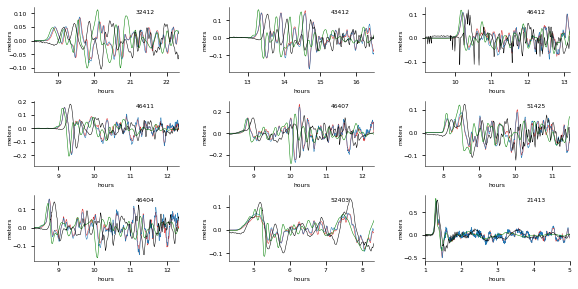

In [11]:
f = plt.figure(figsize=(12 / 1.5, 6 / 1.5))
for i, dart_number in enumerate(orderedBuoys):
    ax = f.add_subplot(3, 3, i + 1)

    ax.plot(
        ewave["Minute"] / 60.0,
        ewave[str(dart_number)],
        label="easywave",
        color="#d62728",
        linewidth=0.5,
    )
    ax.plot(
        np.array(nami[dart_number].time) / 60 / 60,
        nami[dart_number].surface,
        label="nami",
        linewidth=0.5,
    )
    ax.plot(
        geoclaw[dart_number].t / 60 / 60,
        geoclaw[dart_number].q[3, :],
        color="g",
        linewidth=0.5,
        label="geoclaw",
    )    
    ax.plot(
        darts[dart_number][:, 0] * 24,
        darts[dart_number][:, 1],
        label="dart buoy",
        color="k",
        linewidth=0.5,
    )


    xmin = min(starts[dart_number] / 60, 20)
    xmax = min(starts[dart_number] / 60 + 4, 25)
    ax.set_xlim(xmin, xmax)
    ax.annotate("%s" % dart_number, [0.7, 0.9], xycoords="axes fraction")
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)

    ax.spines["bottom"].set_linewidth(0.5)
    xticks = np.arange(np.ceil(xmin), np.ceil(xmax + 0.5), 1, dtype=int)
    ax.set_xticks(xticks)
#     if dart_number in group1:
#         ax.set_ylim(-0.15, 0.25)
#         ax.set_yticks(np.arange(-0.1, 0.2, 0.1))
#     elif dart_number in group2:
#         ax.set_ylim(-0.05, 0.07)
#         ax.set_yticks(np.arange(-0.05, 0.051, 0.05))

    ax.set_xlabel("hours")
    ax.set_ylabel("meters")


f.tight_layout()
f.subplots_adjust(wspace=0.35)
f.savefig("timeseries2011.png", dpi=300, bbox_inches="tight")

<img src="./timeseries2011.png"></img>

# Calculation of phase shift

Based on the arrival of the first peak

In [12]:
edited_starts = {
    32412: 19,
    43412: 13,
    46412: 10,
    46411: 9,
    46407: 8,
    51425: 8, 
    46404: 8,
    52403: 4, 
    21413: 1
}
ends = {
    32412: 19.5,
    43412: 13.5,
    46412: 11,
    46411: 11,
    46407: 9.5,
    51425: 9, 
    46404: 9.5,
    52403: 6,     
    21413: 2
}

In [13]:
def get_max_and_max_loc(t, y, time_to_hours_factor, start=0, end=4):
    t = np.array(t) * time_to_hours_factor
    y = np.array(y)
    is_in_interval = (t > start) * (t < end)
    y_filtered = y[is_in_interval]
    t_filtered = t[is_in_interval]

    if len(t_filtered) == 0:
        return t[-1], y[-1]
    return t_filtered[np.argmax(y_filtered)], np.max(y_filtered)

In [14]:
peaks = {
    "nami": {
        dart_number: get_max_and_max_loc(
            nami[dart_number].time,
            nami[dart_number].surface,
            time_to_hours_factor=1 / 60 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in orderedBuoys
    },
    "easywave": {
        dart_number: get_max_and_max_loc(
            ewave["Minute"], ewave[str(dart_number)], time_to_hours_factor=1 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in orderedBuoys
    },
    "geoclaw": {
        dart_number: get_max_and_max_loc(
            geoclaw[dart_number].t, geoclaw[dart_number].q[3, :], time_to_hours_factor=1 / 60 / 60,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in orderedBuoys
    },
    "measurements": {
        dart_number: get_max_and_max_loc(
            darts[dart_number][:, 0], darts[dart_number][:, 1], time_to_hours_factor=24,
            start=edited_starts[dart_number],
            end=ends[dart_number]
        )
        for dart_number in orderedBuoys
    },
}

In [15]:
times = {
    model: np.array([
        peaks[model][dart_number][0]
        for dart_number in orderedBuoys
    ])
    for model in peaks 
}

differences = {
    model: np.array([
        peaks[model][dart_number][0] - peaks["measurements"][dart_number][0]
        for dart_number in orderedBuoys
    ])
    for model in peaks if model != "measurements"
}

# Arrival times sorted by arrival at the buoy

In [16]:
order_by_earliest_index = np.argsort(times["measurements"])

In [17]:
buoys_sorted_by_earliest = [orderedBuoys[index] for index in order_by_earliest_index]

In [18]:
orderedBuoys

[32412, 43412, 46412, 46411, 46407, 51425, 46404, 52403, 21413]

In [19]:
buoys_sorted_by_earliest

[21413, 52403, 51425, 46404, 46407, 46411, 46412, 43412, 32412]

(array([0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6, 7.6, 8.6]),
 <a list of 9 Text major ticklabel objects>)

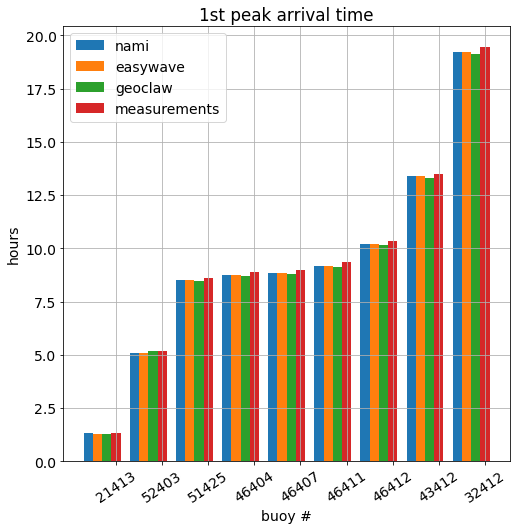

In [20]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

plt.figure(figsize=(8,8))
for i, model in enumerate(times):
    plt.bar(
        np.arange(len(orderedBuoys)) + 0.2 * i,
        times[model][order_by_earliest_index],
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest
    )

plt.xlabel("buoy #")
plt.ylabel("hours")
plt.title("1st peak arrival time")
plt.legend()
plt.grid(which="both")
plt.xticks(rotation=34)

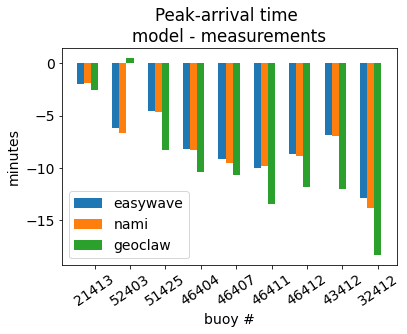

In [21]:
for i, model in enumerate(["easywave", "nami", "geoclaw"]):
    if model == "":
        continue
    plt.bar(
        np.arange(len(orderedBuoys)) + 0.2 * i, 
        differences[model][order_by_earliest_index]*60,
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest,
    )

plt.ylabel("minutes")
plt.xlabel("buoy #")
plt.title("Peak-arrival time \nmodel - measurements")
plt.xticks(rotation=34)
plt.legend()

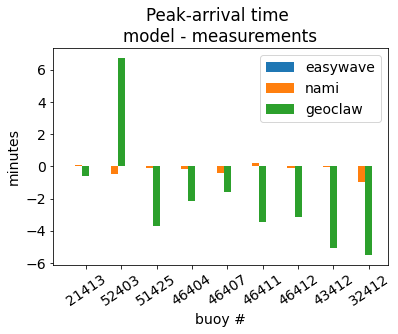

In [22]:
for i, model in enumerate(["easywave", "nami", "geoclaw"]):
    plt.bar(
        np.arange(len(orderedBuoys)) + 0.2 * i, 
        differences[model][order_by_earliest_index]*60 - differences["easywave"][order_by_earliest_index]*60,
        width=0.2,
        label=model,
        tick_label=buoys_sorted_by_earliest,
    )

plt.ylabel("minutes")
plt.xlabel("buoy #")
plt.title("Peak-arrival time \nmodel - measurements")
plt.xticks(rotation=34)
plt.legend()

# Shifted time series plots

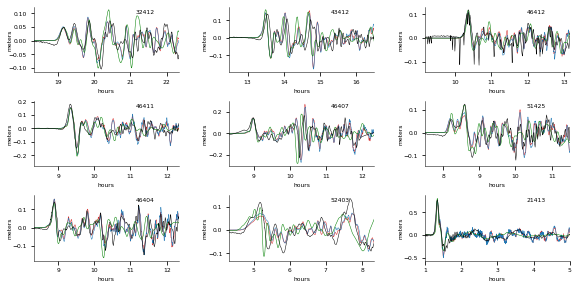

In [23]:
font = {'size'   : 6}
matplotlib.rc('font', **font)
f = plt.figure(figsize=(12 / 1.5, 6 / 1.5))
for i, dart_number in enumerate(orderedBuoys):
    ax = f.add_subplot(3, 3, i + 1)

    ax.plot(
        ewave["Minute"] / 60.0 - differences["easywave"][i],
        ewave[str(dart_number)] ,
        label="easywave",
        color="#d62728",
        linewidth=0.5,
    )
    ax.plot(
        np.array(nami[dart_number].time) / 60 / 60 - differences["nami"][i],
        nami[dart_number].surface,
        label="nami",
        linewidth=0.5,
    )
    ax.plot(
        geoclaw[dart_number].t / 60 / 60 - differences["geoclaw"][i],
        geoclaw[dart_number].q[3, :],
        color="g",
        linewidth=0.5,
        label="geoclaw",
    )    
    ax.plot(
        darts[dart_number][:, 0] * 24,
        darts[dart_number][:, 1],
        label="dart buoy",
        color="k",
        linewidth=0.5,
    )


    xmin = min(starts[dart_number] / 60, 20)
    xmax = min(starts[dart_number] / 60 + 4, 25)
    ax.set_xlim(xmin, xmax)
    ax.annotate("%s" % dart_number, [0.7, 0.9], xycoords="axes fraction")
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)

    ax.spines["bottom"].set_linewidth(0.5)
    xticks = np.arange(np.ceil(xmin), np.ceil(xmax + 0.5), 1, dtype=int)
    ax.set_xticks(xticks)
#     if dart_number in group1:
#         ax.set_ylim(-0.15, 0.25)
#         ax.set_yticks(np.arange(-0.1, 0.2, 0.1))
#     elif dart_number in group2:
#         ax.set_ylim(-0.05, 0.07)
#         ax.set_yticks(np.arange(-0.05, 0.051, 0.05))

    ax.set_xlabel("hours")
    ax.set_ylabel("meters")


f.tight_layout()
f.subplots_adjust(wspace=0.35)
f.savefig("timeseries2011_shifted.png", dpi=300, bbox_inches="tight")

<img src="./timeseries2011_shifted.png"></img>

In [28]:
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
fancy_table = pd.DataFrame.from_dict({**{"buoys": orderedBuoys, "arrival": times["measurements"]/60}, **differences }).set_index("buoys").sort_values("arrival") * 60 

In [30]:
fancy_table

,arrival,nami,easywave,geoclaw
buoys,,,,
21413,1.34,-1.90,-2.00,-2.57
52403,5.18,-6.68,-6.22,0.53
51425,8.59,-4.64,-4.57,-8.25
46404,8.89,-8.33,-8.19,-10.35
46407,8.99,-9.49,-9.10,-10.71
46411,9.34,-9.83,-10.05,-13.48
46412,10.36,-8.81,-8.69,-11.83
43412,13.50,-6.91,-6.89,-11.97
32412,19.45,-13.81,-12.83,-18.37


In [33]:
print(fancy_table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  arrival &   nami &  easywave &  geoclaw \\
buoys &          &        &           &          \\
\midrule
21413 &     1.34 &  -1.90 &     -2.00 &    -2.57 \\
52403 &     5.18 &  -6.68 &     -6.22 &     0.53 \\
51425 &     8.59 &  -4.64 &     -4.57 &    -8.25 \\
46404 &     8.89 &  -8.33 &     -8.19 &   -10.35 \\
46407 &     8.99 &  -9.49 &     -9.10 &   -10.71 \\
46411 &     9.34 &  -9.83 &    -10.05 &   -13.48 \\
46412 &    10.36 &  -8.81 &     -8.69 &   -11.83 \\
43412 &    13.50 &  -6.91 &     -6.89 &   -11.97 \\
32412 &    19.45 & -13.81 &    -12.83 &   -18.37 \\
\bottomrule
\end{tabular}



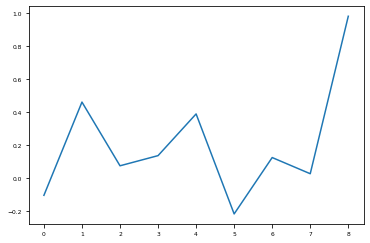

In [34]:
plt.plot(np.array((fancy_table["easywave"] - fancy_table["nami"])))